# Introduction to Sentiment Analysis and Prediction
In this final file, I’m bringing it all together to analyze and compare the sentiment measures I’ve built. I’ll load the BoW and LLM sentiment scores, calculate their correlations, and test which ones best predict stock market reactions after earnings calls. I’ll also explore whether sentiment from the full transcript, management presentation, or Q&A section holds the most predictive power. This step ties my work into a cohesive analysis, delivering insights for my NLP for Finance assignment.

In [285]:
### Core packages
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [286]:
### Importing data from sqlite database
conn = sql.connect('data.db')
ECs = pd.read_sql_query("SELECT * from ECs4", conn)
bert = pd.read_sql_query("SELECT * from bart", conn)
openai = pd.read_sql_query("SELECT * from openai", conn)
bow = pd.read_sql_query("SELECT * from bow", conn)
conn.close()

### Turning openai into only numeric
openai['openai_P'] = pd.to_numeric(openai['openai_P'], errors='coerce')
openai['openai_P'] = openai['openai_P'].fillna(0)

In [287]:
### Filling in the data
ECs[bow.columns] = bow
ECs[bert.columns] = bert
ECs[openai.columns] = openai

### Renaming openai_P to openai
ECs.rename(columns={'openai_P': 'openai'}, inplace=True)

In [288]:
### Standarizing each columns
def standardize(column):
    return (column - column.mean()) / column.std()

openai['openai_P'] = standardize(openai['openai_P'])
bow = bow.apply(standardize, axis=0)
bert = bert.apply(standardize, axis=0)

# Correlations

### BoW

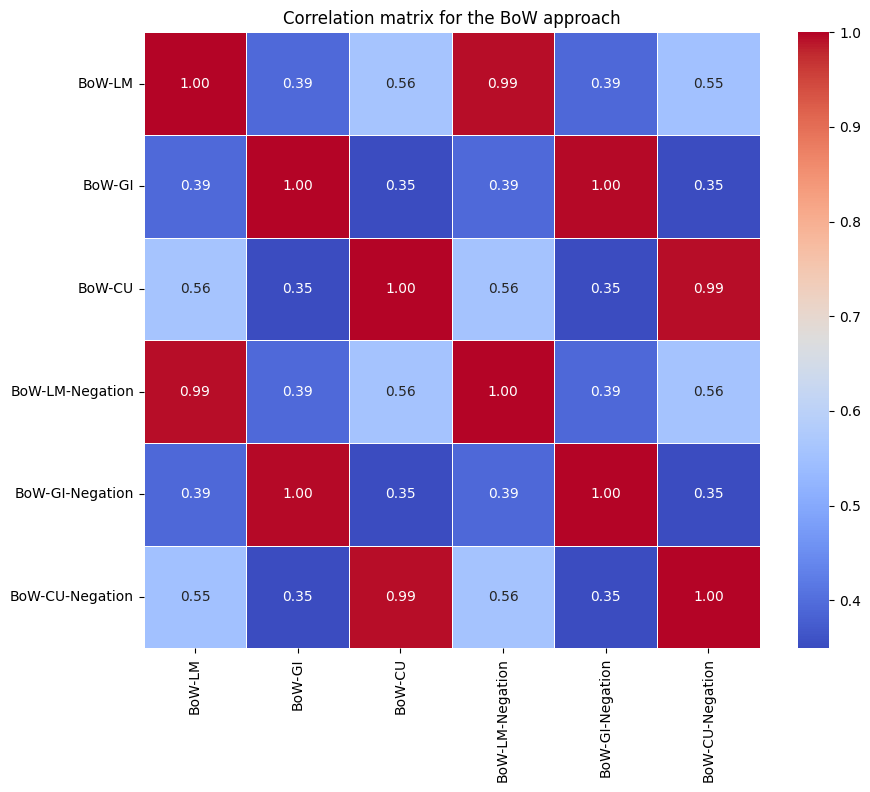

In [289]:
### Changing the columns names to be more readable
bow.columns = ['BoW-LM', 'BoW-GI', 'BoW-CU', 'BoW-LM-Negation', 'BoW-GI-Negation', 'BoW-CU-Negation']

### Getting the correlation matrix
corr_bow = bow.corr()

### Saving the correlation matrix as a latex table
corr_bow.to_latex('figures_and_tables/bow_corr.tex', float_format="%.2f", escape=False, label='tab:bow_corr', caption='Correlation matrix for the BoW approch')

### Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_bow, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title('Correlation matrix for the BoW approach')
plt.savefig('figures_and_tables/bow_corr.png', dpi=300, bbox_inches='tight')
plt.show()

### BERT

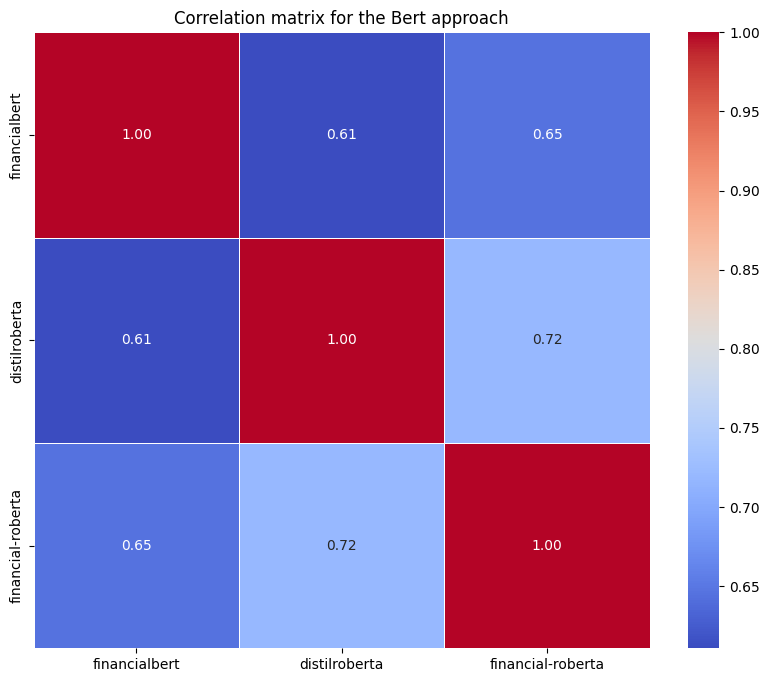

In [290]:
### Getting the correlation matrix
corr_bert = bert.corr()

### Saving the correlation matrix as a latex table
corr_bert.to_latex('figures_and_tables/bert_corr.tex', float_format="%.2f", escape=False, label='tab:bert_corr', caption='Correlation matrix for the BERT approch')

### Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_bert, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title('Correlation matrix for the Bert approach')
plt.savefig('figures_and_tables/bow_corr.png', dpi=300, bbox_inches='tight')
plt.show()

### All models

In [291]:
ECs.columns

Index(['GVKEY', 'date_rdq', 'co_conm', 'file_name', 'CAR-11-Carhart',
       'CAR-11-ff3', 'CAR01-Carhart', 'CAR01-ff3', 'IV', 'hvol', 'IV_l1d',
       'IV_l2d', 'IV_f1d', 'NUMEST', 'NUMUP', 'NUMDOWN', 'MEDEST', 'MEANEST',
       'ACTUAL', 'surp', 'SurpDec', 'atq', 'actq', 'cheq', 'rectq', 'invtq',
       'ltq', 'lctq', 'apq', 'ceqq', 'seqq', 'capxy', 'dpq', 'saleq', 'cogsq',
       'oiadpq', 'niq', 'epspxq', 'epspiq', 'dlttq', 'dlcq', 'prccq', 'cshoq',
       'dvpq', 'xintq', 'A', 'Q', 'QA', 'P', 'PA', 'SurpDec2', 'P_cleaned',
       'A_cleaned', 'PA_cleaned', 'bow_lm', 'bow_gi', 'bow_cu', 'bow_lm_neg',
       'bow_gi_neg', 'bow_cu_neg', 'bow_lm_if_pos', 'bow_lm_if_neg',
       'bow_lm_neg_if_pos', 'bow_lm_neg_if_neg', 'bow_gi_if_pos',
       'bow_gi_if_neg', 'bow_gi_neg_if_pos', 'bow_gi_neg_if_neg',
       'bow_cu_if_pos', 'bow_cu_if_neg', 'bow_cu_neg_if_pos',
       'bow_cu_neg_if_neg', 'year', 'quarter', 'financialbert',
       'distilroberta', 'financial-roberta', 'openai'],
     

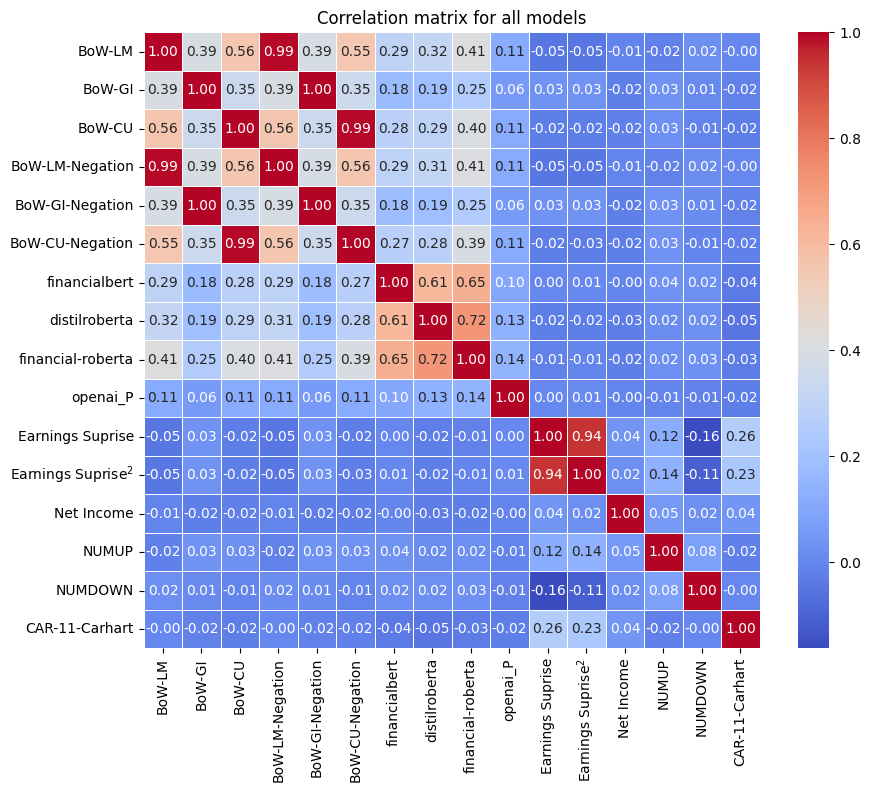

In [292]:
### Combining the dataframes
control = ECs[['SurpDec', 'SurpDec2', 'niq', 'NUMUP', 'NUMDOWN', 'CAR-11-Carhart']]
control.columns = ['Earnings Suprise', 'Earnings Suprise$^2$', 'Net Income', 'NUMUP', 'NUMDOWN', 'CAR-11-Carhart']
all_models = pd.concat([bow, bert, openai, control], axis=1)

### Getting the correlation matrix
corr_all_models = all_models.corr()

### Saving the correlation matrix as a latex table
corr_all_models.to_latex('figures_and_tables/all_models_corr.tex', float_format="%.2f", escape=False, label='tab:all_models_corr', caption='Correlation matrix for all models')

### Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_all_models, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title('Correlation matrix for all models')
plt.savefig('figures_and_tables/all_models_corr.png', dpi=300, bbox_inches='tight')
plt.show()

# Regressions

In [230]:
### Function to run regressions
def run_reg(sentiment_value=['bow_lm'], 
            control_variables=['SurpDec', 'SurpDec2', 'niq', 'NUMUP', 'NUMDOWN'], 
            dependent_variable=['CAR-11-Carhart'],
            Dummies=None, print_summary=True, save_dummy=False):
    """
    Run a regression model using the specified sentiment value and control variables.
    
    Args:
        sentiment_value (str): The column name for the sentiment value to use in the regression.
        control_variables (list): List of control variable column names.
        dependent_variable (str): The column name for the dependent variable.
    
    Returns:
        All coefficients, t-values, and R-squared value of the regression model.
    """
    # Prepare the data
    y = ECs[dependent_variable]
    X = ECs[control_variables + sentiment_value]
    X = sm.add_constant(X)

    # Check if Dummies is provided
    if Dummies == 'C':
        X = X.join(pd.get_dummies(ECs['co_conm'], prefix='company', drop_first=True, dtype='int'))
    elif Dummies == 'Q':
        ECs['quarter'] = pd.to_datetime(ECs['date_rdq']).dt.to_period('Q').astype(str)
        X = X.join(pd.get_dummies(ECs['quarter'], prefix='quarter', drop_first=True, dtype='int'))
    elif Dummies == 'Y':
        ECs['year'] = pd.to_datetime(ECs['date_rdq']).dt.year.astype(str)
        X = X.join(pd.get_dummies(ECs['year'], prefix='year', drop_first=True, dtype='int'))
    elif Dummies == 'CQ' or Dummies == 'QC':
        X = X.join(pd.get_dummies(ECs['co_conm'], prefix='company', drop_first=True, dtype='int'))
        ECs['quarter'] = pd.to_datetime(ECs['date_rdq']).dt.to_period('Q').astype(str)
        X = X.join(pd.get_dummies(ECs['quarter'], prefix='quarter', drop_first=True, dtype='int'))
    elif Dummies == 'CY' or Dummies == 'YC':
        X = X.join(pd.get_dummies(ECs['co_conm'], prefix='company', drop_first=True, dtype='int'))
        ECs['year'] = pd.to_datetime(ECs['date_rdq']).dt.year.astype(str)
        X = X.join(pd.get_dummies(ECs['year'], prefix='year', drop_first=True, dtype='int'))
    elif Dummies == None:
        pass
    else:
        raise ValueError("Dummies must be 'C', 'Q', 'Y', 'CQ', 'CY', 'QC', 'YC', or None.")

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Check if we need to save the dummy variables
    if save_dummy is True:
        lenght = len(X.columns)
    elif save_dummy is False:
        lenght = len(X[control_variables + sentiment_value].columns)
    

    # Saving the results
    results = []
    if save_dummy is True:
        for i in range(lenght):
            results.append(model.params[i])  # Coefficients
            results.append(model.tvalues[i])  # t-values
    elif save_dummy is False:
        for i in range(len(control_variables + sentiment_value) + 1):
            results.append(model.params[i])
            results.append(model.tvalues[i])
    else:
        raise ValueError("save_dummy must be True or False.")

    # R-squared
    results.append(model.rsquared)

    # Print the summary if requested
    if print_summary:
        print(model.summary())

    return results

# Bag-of-Words without time-fixed and company-fixed effects

In [231]:
### Creating a place to store the regressions
bow_regressions = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
for i in ['bow_lm', 'bow_gi', 'bow_cu', 'bow_lm_neg', 'bow_gi_neg', 'bow_cu_neg']:
    print(f"\n Running regression for {i}: \n")
    bow_regressions[i] = run_reg([i])


 Running regression for bow_lm: 

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     37.96
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           1.57e-44
Time:                        19:18:53   Log-Likelihood:                 3998.7
No. Observations:                2817   AIC:                            -7983.
Df Residuals:                    2810   BIC:                            -7942.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.

In [232]:
### Saving the results as a latex table
bow_regressions.to_latex('figures_and_tables/table-bow_regressions.tex', float_format="%.3f", 
                          column_format='lcccccc', 
                          multirow=True, 
                          multicolumn=True, 
                          label='tab:bow_regressions', 
                          caption='Regression results for the BoW sentiment analysis using different dictionaries and negations.')

bow_regressions

,bow_lm,bow_gi,bow_cu,bow_lm_neg,bow_gi_neg,bow_cu_neg
Alpha,-0.010891,-0.009113,-0.011784,-0.010853,-0.009118,-0.011722
Alpha t-stat,-4.930241,-3.405788,-6.594861,-4.938230,-3.415850,-6.567956
Earnings Surprise,0.011506,0.011530,0.011501,0.011505,0.011525,0.011505
Earnings Suprise t-stat,7.011171,7.026706,7.009140,7.010750,7.023991,7.011194
Earnings Surprise^2,-0.000965,-0.000969,-0.000970,-0.000964,-0.000968,-0.000971
Earnings Suprise^2 t-stat,-2.182850,-2.193175,-2.195986,-2.181178,-2.190599,-2.196584
Net Income,0.001207,0.001182,0.001193,0.001207,0.001182,0.001194
Net Income t-stat,1.823563,1.785994,1.801905,1.822798,1.785505,1.804075
NUMUP,-0.001098,-0.001087,-0.001090,-0.001098,-0.001086,-0.001092
NUMUP t-stat,-2.937692,-2.909778,-2.916346,-2.938721,-2.905219,-2.921566


Not a single significant sentiment value for any of our BoW approaches. All the $R^2$ values are close to 7.5%.

# Splitting sentiment into two when earnings are positive and negative

In [233]:
### Creating variables that are dependent on if 'SurpDec' is postive or negative
ECs['bow_lm_if_pos'] = np.where(ECs['SurpDec'] > 0, ECs['bow_lm'], 0)
ECs['bow_lm_if_neg'] = np.where(ECs['SurpDec'] < 0, ECs['bow_lm'], 0)
ECs['bow_lm_neg_if_pos'] = np.where(ECs['SurpDec'] < 0, ECs['bow_lm'], 0)
ECs['bow_lm_neg_if_neg'] = np.where(ECs['SurpDec'] > 0, ECs['bow_lm'], 0)

ECs['bow_gi_if_pos'] = np.where(ECs['SurpDec'] > 0, ECs['bow_gi'], 0)
ECs['bow_gi_if_neg'] = np.where(ECs['SurpDec'] < 0, ECs['bow_gi'], 0)
ECs['bow_gi_neg_if_pos'] = np.where(ECs['SurpDec'] < 0, ECs['bow_gi'], 0)
ECs['bow_gi_neg_if_neg'] = np.where(ECs['SurpDec'] > 0, ECs['bow_gi'], 0)

ECs['bow_cu_if_pos'] = np.where(ECs['SurpDec'] > 0, ECs['bow_cu'], 0)
ECs['bow_cu_if_neg'] = np.where(ECs['SurpDec'] < 0, ECs['bow_cu'], 0)
ECs['bow_cu_neg_if_pos'] = np.where(ECs['SurpDec'] < 0, ECs['bow_cu'], 0)
ECs['bow_cu_neg_if_neg'] = np.where(ECs['SurpDec'] > 0, ECs['bow_cu'], 0)

### Creating a place to store the regressions
bow_regressions_split = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat', 
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat',
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_split['lm'] = run_reg(['bow_lm_if_pos', 'bow_lm_if_neg'])
bow_regressions_split['lm_neg'] = run_reg(['bow_lm_neg_if_pos', 'bow_lm_neg_if_neg'])
bow_regressions_split['gi'] = run_reg(['bow_gi_if_pos', 'bow_gi_if_neg'])
bow_regressions_split['gi_neg'] = run_reg(['bow_gi_neg_if_pos', 'bow_gi_neg_if_neg'])
bow_regressions_split['cu'] = run_reg(['bow_cu_if_pos', 'bow_cu_if_neg'])
bow_regressions_split['cu_neg'] = run_reg(['bow_cu_neg_if_pos', 'bow_cu_neg_if_neg'])

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     32.78
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           4.47e-44
Time:                        19:18:54   Log-Likelihood:                 3999.5
No. Observations:                2817   AIC:                            -7983.
Df Residuals:                    2809   BIC:                            -7936.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0098      0.002     -4.416

In [234]:
### Saving the results as a latex table
bow_regressions_split.to_latex('figures_and_tables/table-bow_regressions_split.tex', float_format="%.3f", 
                          column_format='lcccccc', 
                          multirow=True, 
                          multicolumn=True, 
                          label='tab:bow_regressions_split', 
                          caption='Regression results for the BoW sentiment analysis using different dictionaries and negations where sentiment is split.')

bow_regressions_split

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,-0.009801,-0.009801,-0.010846,-0.010846,-0.011479,-0.011479
Alpha t-stat,-4.416468,-4.416468,-4.247205,-4.247205,-6.416784,-6.416784
Earnings Surprise,0.010181,0.010181,0.014016,0.014016,0.010988,0.010988
Earnings Suprise t-stat,4.818471,4.818471,5.741751,5.741751,6.608078,6.608078
Earnings Surprise^2,-0.000719,-0.000719,-0.001399,-0.001399,-0.000872,-0.000872
Earnings Suprise^2 t-stat,-1.424307,-1.424307,-2.586851,-2.586851,-1.960196,-1.960196
Net Income,0.001206,0.001206,0.001213,0.001213,0.001216,0.001216
Net Income t-stat,1.822207,1.822207,1.830547,1.830547,1.836693,1.836693
NUMUP,-0.001087,-0.001087,-0.001100,-0.001100,-0.001089,-0.001089
NUMUP t-stat,-2.908159,-2.908159,-2.939893,-2.939893,-2.915399,-2.915399


No significant results for sentiment were observed. The Harvard dictionary approaches yielded results close to significance when negations were included.

# Bow with compamy-fixed effects

In [235]:
### Creating a place to store the regressions
bow_regressions_company_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_company_fixed['lm'] = run_reg(['bow_lm'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_company_fixed['lm_neg'] = run_reg(['bow_lm_neg'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_company_fixed['gi'] = run_reg(['bow_gi'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_company_fixed['gi_neg'] = run_reg(['bow_gi_neg'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_company_fixed['cu'] = run_reg(['bow_cu'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_company_fixed['cu_neg'] = run_reg(['bow_cu_neg'], Dummies='C', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.057
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           2.74e-14
Time:                        19:18:54   Log-Likelihood:                 4081.2
No. Observations:                2817   AIC:                            -7786.
Df Residuals:                    2629   BIC:                            -6669.
Df Model:                         187                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [236]:
### Saving the results as a latex table
bow_regressions_company_fixed.to_latex('figures_and_tables/table-bow_regressions_company_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_company_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations accounting for company-fixed effects.')

bow_regressions_company_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,-0.003285,-0.003254,0.000632,0.000598,-0.004732,-0.004551
Alpha t-stat,-0.236266,-0.234010,0.044367,0.041961,-0.341998,-0.328945
Earnings Surprise,0.010668,0.010667,0.010690,0.010687,0.010676,0.010679
Earnings Suprise t-stat,5.820871,5.820554,5.834500,5.832760,5.826508,5.827772
Earnings Surprise^2,-0.000580,-0.000580,-0.000580,-0.000579,-0.000585,-0.000586
Earnings Suprise^2 t-stat,-1.176915,-1.175525,-1.176269,-1.174606,-1.186766,-1.189351
Net Income,0.001775,0.001776,0.001722,0.001718,0.001727,0.001727
Net Income t-stat,1.427239,1.428497,1.385689,1.382645,1.390293,1.389812
NUMUP,-0.000791,-0.000791,-0.000790,-0.000787,-0.000801,-0.000800
NUMUP t-stat,-1.567429,-1.568825,-1.567441,-1.561284,-1.590468,-1.586653


In [237]:
### Creating a place to store the regressions
bow_regressions_split_company_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_split_company_fixed['lm'] = run_reg(['bow_lm_if_pos', 'bow_lm_if_neg'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_split_company_fixed['lm_neg'] = run_reg(['bow_lm_neg_if_pos', 'bow_lm_neg_if_neg'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_split_company_fixed['gi'] = run_reg(['bow_gi_if_pos', 'bow_gi_if_neg'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_split_company_fixed['gi_neg'] = run_reg(['bow_gi_neg_if_pos', 'bow_gi_neg_if_neg'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_split_company_fixed['cu'] = run_reg(['bow_cu_if_pos', 'bow_cu_if_neg'], Dummies='C', print_summary=True, save_dummy=False)
bow_regressions_split_company_fixed['cu_neg'] = run_reg(['bow_cu_neg_if_pos', 'bow_cu_neg_if_neg'], Dummies='C', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.056
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           2.43e-14
Time:                        19:18:54   Log-Likelihood:                 4082.2
No. Observations:                2817   AIC:                            -7786.
Df Residuals:                    2628   BIC:                            -6663.
Df Model:                         188                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [238]:
### Saving the results as a latex table
bow_regressions_split_company_fixed.to_latex('figures_and_tables/table-bow_regressions_split_company_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_split_company_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations where sentiment is split and accounting for company-fixed effects.')

bow_regressions_split_company_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,-0.002183,-0.002183,-0.000846,-0.000846,-0.004970,-0.004970
Alpha t-stat,-0.157087,-0.157087,-0.059768,-0.059768,-0.359350,-0.359350
Earnings Surprise,0.009403,0.009403,0.014025,0.014025,0.010050,0.010050
Earnings Suprise t-stat,4.059978,4.059978,5.361083,5.361083,5.409932,5.409932
Earnings Surprise^2,-0.000348,-0.000348,-0.001144,-0.001144,-0.000464,-0.000464
Earnings Suprise^2 t-stat,-0.626366,-0.626366,-1.956790,-1.956790,-0.934560,-0.934560
Net Income,0.001781,0.001781,0.001802,0.001802,0.001747,0.001747
Net Income t-stat,1.433000,1.433000,1.450074,1.450074,1.406641,1.406641
NUMUP,-0.000769,-0.000769,-0.000805,-0.000805,-0.000781,-0.000781
NUMUP t-stat,-1.522574,-1.522574,-1.597477,-1.597477,-1.550800,-1.550800


# Bow with year-fixed effects

In [239]:
### Creating a place to store the regressions
bow_regressions_year_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_year_fixed['lm'] = run_reg(['bow_lm'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_year_fixed['lm_neg'] = run_reg(['bow_lm_neg'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_year_fixed['gi'] = run_reg(['bow_gi'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_year_fixed['gi_neg'] = run_reg(['bow_gi_neg'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_year_fixed['cu'] = run_reg(['bow_cu'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_year_fixed['cu_neg'] = run_reg(['bow_cu_neg'], Dummies='Y', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     23.58
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           4.21e-43
Time:                        19:18:55   Log-Likelihood:                 4002.6
No. Observations:                2817   AIC:                            -7983.
Df Residuals:                    2806   BIC:                            -7918.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0082      0.003     -2.491      0.0

In [240]:
### Saving the results as a latex table
bow_regressions_year_fixed.to_latex('figures_and_tables/table-bow_regressions_year_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_year_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations accounting for year-fixed effects.')

bow_regressions_year_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,-0.008241,-0.008190,-0.006630,-0.006615,-0.008992,-0.008953
Alpha t-stat,-2.491406,-2.479784,-1.840521,-1.838404,-2.960157,-2.947560
Earnings Surprise,0.011471,0.011470,0.011496,0.011492,0.011469,0.011473
Earnings Suprise t-stat,6.961386,6.961026,6.977308,6.975046,6.960540,6.962462
Earnings Surprise^2,-0.000928,-0.000928,-0.000933,-0.000932,-0.000934,-0.000934
Earnings Suprise^2 t-stat,-2.085723,-2.084086,-2.097682,-2.095434,-2.098914,-2.099499
Net Income,0.001187,0.001187,0.001165,0.001164,0.001174,0.001175
Net Income t-stat,1.791988,1.791375,1.757645,1.756931,1.771352,1.772950
NUMUP,-0.000995,-0.000995,-0.000986,-0.000984,-0.000986,-0.000988
NUMUP t-stat,-2.648571,-2.649346,-2.623920,-2.619062,-2.624320,-2.629042


In [241]:
### Creating a place to store the regressions
bow_regressions_split_year_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_split_year_fixed['lm'] = run_reg(['bow_lm_if_pos', 'bow_lm_if_neg'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_split_year_fixed['lm_neg'] = run_reg(['bow_lm_neg_if_pos', 'bow_lm_neg_if_neg'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_split_year_fixed['gi'] = run_reg(['bow_gi_if_pos', 'bow_gi_if_neg'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_split_year_fixed['gi_neg'] = run_reg(['bow_gi_neg_if_pos', 'bow_gi_neg_if_neg'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_split_year_fixed['cu'] = run_reg(['bow_cu_if_pos', 'bow_cu_if_neg'], Dummies='Y', print_summary=True, save_dummy=False)
bow_regressions_split_year_fixed['cu_neg'] = run_reg(['bow_cu_neg_if_pos', 'bow_cu_neg_if_neg'], Dummies='Y', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     21.59
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           9.43e-43
Time:                        19:18:55   Log-Likelihood:                 4003.4
No. Observations:                2817   AIC:                            -7983.
Df Residuals:                    2805   BIC:                            -7911.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0072      0.003     -2.165

In [242]:
### Saving the results as a latex table
bow_regressions_split_year_fixed.to_latex('figures_and_tables/table-bow_regressions_split_year_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_split_year_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations where sentiment is split and accounting for year-fixed effects.')

bow_regressions_split_year_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,-0.007158,-0.007158,-0.008441,-0.008441,-0.008648,-0.008648
Alpha t-stat,-2.165034,-2.165034,-2.390026,-2.390026,-2.844470,-2.844470
Earnings Surprise,0.010083,0.010083,0.013888,0.013888,0.010992,0.010992
Earnings Suprise t-stat,4.760000,4.760000,5.673519,5.673519,6.587496,6.587496
Earnings Surprise^2,-0.000671,-0.000671,-0.001348,-0.001348,-0.000845,-0.000845
Earnings Suprise^2 t-stat,-1.322163,-1.322163,-2.477873,-2.477873,-1.887156,-1.887156
Net Income,0.001185,0.001185,0.001195,0.001195,0.001198,0.001198
Net Income t-stat,1.789073,1.789073,1.802050,1.802050,1.808170,1.808170
NUMUP,-0.000984,-0.000984,-0.000999,-0.000999,-0.000988,-0.000988
NUMUP t-stat,-2.620551,-2.620551,-2.656930,-2.656930,-2.629206,-2.629206


# Bow with quarter-fixed effects

In [243]:
### Creating a place to store the regressions
bow_regressions_quarter_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_quarter_fixed['lm'] = run_reg(['bow_lm'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_quarter_fixed['lm_neg'] = run_reg(['bow_lm_neg'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_quarter_fixed['gi'] = run_reg(['bow_gi'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_quarter_fixed['gi_neg'] = run_reg(['bow_gi_neg'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_quarter_fixed['cu'] = run_reg(['bow_cu'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_quarter_fixed['cu_neg'] = run_reg(['bow_cu_neg'], Dummies='Q', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     10.98
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           1.55e-41
Time:                        19:18:55   Log-Likelihood:                 4021.0
No. Observations:                2817   AIC:                            -7990.
Df Residuals:                    2791   BIC:                            -7836.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0076      0.016     -0.

In [244]:
### Saving the results as a latex table
bow_regressions_quarter_fixed.to_latex('figures_and_tables/table-bow_regressions_quarter_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_quarter_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations accounting for quarter-fixed effects.')

bow_regressions_quarter_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,-0.007574,-0.007478,-0.006596,-0.006606,-0.009032,-0.008951
Alpha t-stat,-0.481482,-0.475427,-0.419447,-0.420162,-0.577744,-0.572552
Earnings Surprise,0.011347,0.011346,0.011381,0.011376,0.011347,0.011351
Earnings Suprise t-stat,6.886161,6.885613,6.906602,6.904268,6.886608,6.888546
Earnings Surprise^2,-0.000844,-0.000843,-0.000853,-0.000852,-0.000852,-0.000853
Earnings Suprise^2 t-stat,-1.889689,-1.887548,-1.910368,-1.908135,-1.908344,-1.908819
Net Income,0.001238,0.001238,0.001214,0.001214,0.001221,0.001223
Net Income t-stat,1.873087,1.872465,1.836409,1.835641,1.847134,1.849074
NUMUP,-0.000960,-0.000960,-0.000954,-0.000952,-0.000952,-0.000954
NUMUP t-stat,-2.550764,-2.551855,-2.533819,-2.529324,-2.529723,-2.533948


In [245]:
### Creating a place to store the regressions
bow_regressions_split_quarter_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_split_quarter_fixed['lm'] = run_reg(['bow_lm_if_pos', 'bow_lm_if_neg'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_split_quarter_fixed['lm_neg'] = run_reg(['bow_lm_neg_if_pos', 'bow_lm_neg_if_neg'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_split_quarter_fixed['gi'] = run_reg(['bow_gi_if_pos', 'bow_gi_if_neg'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_split_quarter_fixed['gi_neg'] = run_reg(['bow_gi_neg_if_pos', 'bow_gi_neg_if_neg'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_split_quarter_fixed['cu'] = run_reg(['bow_cu_if_pos', 'bow_cu_if_neg'], Dummies='Q', print_summary=True, save_dummy=False)
bow_regressions_split_quarter_fixed['cu_neg'] = run_reg(['bow_cu_neg_if_pos', 'bow_cu_neg_if_neg'], Dummies='Q', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     10.63
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           2.22e-41
Time:                        19:18:55   Log-Likelihood:                 4022.0
No. Observations:                2817   AIC:                            -7990.
Df Residuals:                    2790   BIC:                            -7829.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0067      0.016     -0.

In [246]:
### Saving the results as a latex table
bow_regressions_split_quarter_fixed.to_latex('figures_and_tables/table-bow_regressions_split_quarter_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_split_quarter_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations where sentiment is split and accounting for quarter-fixed effects.')

bow_regressions_split_quarter_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,-0.006675,-0.006675,-0.008473,-0.008473,-0.009005,-0.009005
Alpha t-stat,-0.425196,-0.425196,-0.538604,-0.538604,-0.576303,-0.576303
Earnings Surprise,0.009937,0.009937,0.013490,0.013490,0.010859,0.010859
Earnings Suprise t-stat,4.690209,4.690209,5.513774,5.513774,6.507079,6.507079
Earnings Surprise^2,-0.000582,-0.000582,-0.001219,-0.001219,-0.000759,-0.000759
Earnings Suprise^2 t-stat,-1.141639,-1.141639,-2.236044,-2.236044,-1.689335,-1.689335
Net Income,0.001238,0.001238,0.001239,0.001239,0.001246,0.001246
Net Income t-stat,1.872893,1.872893,1.872865,1.872865,1.884866,1.884866
NUMUP,-0.000947,-0.000947,-0.000963,-0.000963,-0.000952,-0.000952
NUMUP t-stat,-2.515732,-2.515732,-2.556077,-2.556077,-2.529711,-2.529711


# BoW with quarter-fixed and company-fixed effects

In [247]:
### Creating a place to store the regressions
bow_regressions_company_and_quarter_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_company_and_quarter_fixed['lm'] = run_reg(['bow_lm'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_company_and_quarter_fixed['lm_neg'] = run_reg(['bow_lm_neg'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_company_and_quarter_fixed['gi'] = run_reg(['bow_gi'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_company_and_quarter_fixed['gi_neg'] = run_reg(['bow_gi_neg'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_company_and_quarter_fixed['cu'] = run_reg(['bow_cu'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_company_and_quarter_fixed['cu_neg'] = run_reg(['bow_cu_neg'], Dummies='CQ', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2.143
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           3.79e-17
Time:                        19:18:55   Log-Likelihood:                 4109.0
No. Observations:                2817   AIC:                            -7804.
Df Residuals:                    2610   BIC:                            -6574.
Df Model:                         206                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [248]:
### Saving the results as a latex table
bow_regressions_company_and_quarter_fixed.to_latex('figures_and_tables/table-bow_regressions_company_and_quarter_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_company_and_quarter_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations accounting for company-fixed and quarter-fixed effects.')

bow_regressions_company_and_quarter_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,-0.002722,-0.002638,0.000089,0.000053,-0.004875,-0.004689
Alpha t-stat,-0.125572,-0.121699,0.004088,0.002429,-0.225638,-0.217006
Earnings Surprise,0.010230,0.010229,0.010270,0.010267,0.010248,0.010250
Earnings Suprise t-stat,5.551095,5.550805,5.573593,5.572104,5.562546,5.563001
Earnings Surprise^2,-0.000333,-0.000332,-0.000341,-0.000340,-0.000342,-0.000342
Earnings Suprise^2 t-stat,-0.665337,-0.663737,-0.681360,-0.679909,-0.683084,-0.684656
Net Income,0.001731,0.001734,0.001682,0.001678,0.001677,0.001676
Net Income t-stat,1.383508,1.385808,1.344777,1.341605,1.341151,1.339697
NUMUP,-0.000451,-0.000452,-0.000463,-0.000460,-0.000462,-0.000460
NUMUP t-stat,-0.871622,-0.873042,-0.895356,-0.889641,-0.893521,-0.888896


In [249]:
### Creating a place to store the regressions
bow_regressions_split_company_and_quarter_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_split_company_and_quarter_fixed['lm'] = run_reg(['bow_lm_if_pos', 'bow_lm_if_neg'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_quarter_fixed['lm_neg'] = run_reg(['bow_lm_neg_if_pos', 'bow_lm_neg_if_neg'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_quarter_fixed['gi'] = run_reg(['bow_gi_if_pos', 'bow_gi_if_neg'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_quarter_fixed['gi_neg'] = run_reg(['bow_gi_neg_if_pos', 'bow_gi_neg_if_neg'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_quarter_fixed['cu'] = run_reg(['bow_cu_if_pos', 'bow_cu_if_neg'], Dummies='CQ', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_quarter_fixed['cu_neg'] = run_reg(['bow_cu_neg_if_pos', 'bow_cu_neg_if_neg'], Dummies='CQ', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.143
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           3.21e-17
Time:                        19:18:56   Log-Likelihood:                 4110.1
No. Observations:                2817   AIC:                            -7804.
Df Residuals:                    2609   BIC:                            -6568.
Df Model:                         207                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [250]:
### Saving the results as a latex table
bow_regressions_split_company_and_quarter_fixed.to_latex('figures_and_tables/table-bow_regressions_split_company_and_quarter_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_split_company_and_quarter_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations where sentiment is split and accounting for company-fixed and quarter-fixed effects.')

bow_regressions_split_company_and_quarter_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,-0.001785,-0.001785,-0.001785,-0.001785,-0.005290,-0.005290
Alpha t-stat,-0.082446,-0.082446,-0.081853,-0.081853,-0.244951,-0.244951
Earnings Surprise,0.008857,0.008857,0.013181,0.013181,0.009666,0.009666
Earnings Suprise t-stat,3.812785,3.812785,5.025361,5.025361,5.179008,5.179008
Earnings Surprise^2,-0.000081,-0.000081,-0.000835,-0.000835,-0.000230,-0.000230
Earnings Suprise^2 t-stat,-0.143122,-0.143122,-1.413222,-1.413222,-0.456975,-0.456975
Net Income,0.001736,0.001736,0.001750,0.001750,0.001706,0.001706
Net Income t-stat,1.387811,1.387811,1.399010,1.399010,1.364939,1.364939
NUMUP,-0.000430,-0.000430,-0.000475,-0.000475,-0.000449,-0.000449
NUMUP t-stat,-0.831038,-0.831038,-0.919535,-0.919535,-0.869518,-0.869518


# BoW with year-fixed and company-fixed effects

In [251]:
### Creating a place to store the regressions
bow_regressions_company_and_year_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_company_and_year_fixed['lm'] = run_reg(['bow_lm'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_company_and_year_fixed['lm_neg'] = run_reg(['bow_lm_neg'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_company_and_year_fixed['gi'] = run_reg(['bow_gi'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_company_and_year_fixed['gi_neg'] = run_reg(['bow_gi_neg'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_company_and_year_fixed['cu'] = run_reg(['bow_cu'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_company_and_year_fixed['cu_neg'] = run_reg(['bow_cu_neg'], Dummies='CY', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2.084
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           4.77e-15
Time:                        19:18:56   Log-Likelihood:                 4087.8
No. Observations:                2817   AIC:                            -7792.
Df Residuals:                    2625   BIC:                            -6650.
Df Model:                         191                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [252]:
### Saving the results as a latex table
bow_regressions_company_and_year_fixed.to_latex('figures_and_tables/table-bow_regressions_company_and_year_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_company_and_year_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations accounting for company-fixed and year-fixed effects.')

bow_regressions_company_and_year_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,0.000790,0.000834,0.004074,0.004075,-0.000540,-0.000380
Alpha t-stat,0.056064,0.059217,0.282870,0.283010,-0.038512,-0.027081
Earnings Surprise,0.010432,0.010431,0.010459,0.010457,0.010446,0.010448
Earnings Suprise t-stat,5.663912,5.663601,5.679666,5.678312,5.672718,5.673274
Earnings Surprise^2,-0.000462,-0.000462,-0.000465,-0.000464,-0.000469,-0.000470
Earnings Suprise^2 t-stat,-0.929039,-0.927715,-0.934786,-0.933338,-0.941806,-0.943514
Net Income,0.001653,0.001654,0.001607,0.001603,0.001611,0.001609
Net Income t-stat,1.321744,1.323136,1.285829,1.282863,1.289674,1.287819
NUMUP,-0.000511,-0.000511,-0.000514,-0.000511,-0.000518,-0.000516
NUMUP t-stat,-1.000447,-1.001133,-1.008205,-1.002191,-1.017084,-1.012507


In [253]:
### Creating a place to store the regressions
bow_regressions_split_company_and_year_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
bow_regressions_split_company_and_year_fixed['lm'] = run_reg(['bow_lm_if_pos', 'bow_lm_if_neg'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_year_fixed['lm_neg'] = run_reg(['bow_lm_neg_if_pos', 'bow_lm_neg_if_neg'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_year_fixed['gi'] = run_reg(['bow_gi_if_pos', 'bow_gi_if_neg'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_year_fixed['gi_neg'] = run_reg(['bow_gi_neg_if_pos', 'bow_gi_neg_if_neg'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_year_fixed['cu'] = run_reg(['bow_cu_if_pos', 'bow_cu_if_neg'], Dummies='CY', print_summary=True, save_dummy=False)
bow_regressions_split_company_and_year_fixed['cu_neg'] = run_reg(['bow_cu_neg_if_pos', 'bow_cu_neg_if_neg'], Dummies='CY', print_summary=True, save_dummy=False)

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2.083
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           4.31e-15
Time:                        19:18:57   Log-Likelihood:                 4088.8
No. Observations:                2817   AIC:                            -7792.
Df Residuals:                    2624   BIC:                            -6644.
Df Model:                         192                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [254]:
### Saving the results as a latex table
bow_regressions_split_company_and_year_fixed.to_latex('figures_and_tables/table-bow_regressions_split_company_and_year_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:bow_regressions_split_company_and_year_fixed', 
                                        caption='Regression results for the BoW sentiment analysis using different dictionaries and negations where sentiment is split and accounting for company-fixed and year-fixed effects.')

bow_regressions_split_company_and_year_fixed

,lm,lm_neg,gi,gi_neg,cu,cu_neg
Alpha,0.001836,0.001836,0.002410,0.002410,-0.000708,-0.000708
Alpha t-stat,0.130414,0.130414,0.168258,0.168258,-0.050521,-0.050521
Earnings Surprise,0.009081,0.009081,0.013639,0.013639,0.009879,0.009879
Earnings Suprise t-stat,3.909313,3.909313,5.194397,5.194397,5.296482,5.296482
Earnings Surprise^2,-0.000215,-0.000215,-0.001006,-0.001006,-0.000362,-0.000362
Earnings Suprise^2 t-stat,-0.383689,-0.383689,-1.705327,-1.705327,-0.723685,-0.723685
Net Income,0.001655,0.001655,0.001688,0.001688,0.001642,0.001642
Net Income t-stat,1.323809,1.323809,1.350514,1.350514,1.314426,1.314426
NUMUP,-0.000491,-0.000491,-0.000534,-0.000534,-0.000507,-0.000507
NUMUP t-stat,-0.961017,-0.961017,-1.048286,-1.048286,-0.994239,-0.994239


# LLM model regressions

In [255]:
### Creating a place to store the regressions
llm_regressions = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
for i in ['financialbert', 'distilroberta', 'financial-roberta', 'openai']:
    print(f"\n Running regression for {i}: \n")
    llm_regressions[i] = run_reg([i])


 Running regression for financialbert: 

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     38.54
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           3.29e-45
Time:                        19:18:57   Log-Likelihood:                 4000.3
No. Observations:                2817   AIC:                            -7987.
Df Residuals:                    2810   BIC:                            -7945.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
cons

In [256]:
### Saving the results as a latex table
llm_regressions.to_latex('figures_and_tables/table-llm_regressions.tex', float_format="%.3f", 
                          column_format='lcccccc', 
                          multirow=True, 
                          multicolumn=True, 
                          label='tab:llm_regressions', 
                          caption='Regression results for the LLM sentiment analysis using different models.')

llm_regressions

,financialbert,distilroberta,financial-roberta,openai
Alpha,0.010286,0.018238,0.005111,0.009061
Alpha t-stat,0.866164,1.524727,0.504640,0.510918
Earnings Surprise,0.011471,0.011501,0.011464,0.011474
Earnings Suprise t-stat,6.993737,7.016272,6.988445,6.992546
Earnings Surprise^2,-0.000958,-0.000975,-0.000959,-0.000959
Earnings Suprise^2 t-stat,-2.169570,-2.209090,-2.170597,-2.169918
Net Income,0.001196,0.001157,0.001176,0.001201
Net Income t-stat,1.808514,1.749211,1.776654,1.814813
NUMUP,-0.001076,-0.001082,-0.001088,-0.001103
NUMUP t-stat,-2.878988,-2.898453,-2.913310,-2.953926


Interesting, here we get signficant results already in the first regression.

In [257]:
### Creating variables that are dependent on if 'SurpDec' is postive or negative
ECs['financialbert_pos'] = np.where(ECs['SurpDec'] > 0, ECs['financialbert'], 0)
ECs['financialbert_neg'] = np.where(ECs['SurpDec'] < 0, ECs['financialbert'], 0)

ECs['distilroberta_pos'] = np.where(ECs['SurpDec'] > 0, ECs['distilroberta'], 0)
ECs['distilroberta_neg'] = np.where(ECs['SurpDec'] < 0, ECs['distilroberta'], 0)

ECs['financial-roberta_pos'] = np.where(ECs['SurpDec'] > 0, ECs['financial-roberta'], 0)
ECs['financial-roberta_neg'] = np.where(ECs['SurpDec'] < 0, ECs['financial-roberta'], 0)

ECs['openai_pos'] = np.where(ECs['SurpDec'] > 0, ECs['openai'], 0)
ECs['openai_neg'] = np.where(ECs['SurpDec'] < 0, ECs['openai'], 0)

### Creating a place to store the regressions
llm_regressions_split = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat', 
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat',
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
llm_regressions_split['financialbert'] = run_reg(['financialbert_pos', 'financialbert_neg'])
llm_regressions_split['distilroberta'] = run_reg(['distilroberta_pos', 'distilroberta_neg'])
llm_regressions_split['financial-roberta'] = run_reg(['financial-roberta_pos', 'financial-roberta_neg'])
llm_regressions_split['openai'] = run_reg(['openai_pos', 'openai_neg'])

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     32.55
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           9.32e-44
Time:                        19:18:57   Log-Likelihood:                 3998.8
No. Observations:                2817   AIC:                            -7982.
Df Residuals:                    2809   BIC:                            -7934.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0092      0.00

In [258]:
### Saving the results as a latex table
llm_regressions_split.to_latex('figures_and_tables/table-llm_regressions_split.tex', float_format="%.3f", 
                          column_format='lcccccc', 
                          multirow=True, 
                          multicolumn=True, 
                          label='tab:llm_regressions_split', 
                          caption='Regression results for the LLM sentiment analysis where sentiment is split.')

llm_regressions_split

,financialbert,distilroberta,financial-roberta,openai
Alpha,-0.009169,-0.008169,-0.008972,-0.009990
Alpha t-stat,-2.294398,-2.041881,-2.277041,-2.436289
Earnings Surprise,0.011440,0.010529,0.011362,0.008690
Earnings Suprise t-stat,2.663950,2.452058,2.716969,1.977636
Earnings Surprise^2,-0.000955,-0.000796,-0.000942,-0.000470
Earnings Suprise^2 t-stat,-1.153926,-0.960329,-1.162398,-0.557413
Net Income,0.001199,0.001186,0.001194,0.001181
Net Income t-stat,1.809478,1.788515,1.801938,1.782586
NUMUP,-0.001083,-0.001074,-0.001082,-0.001079
NUMUP t-stat,-2.890520,-2.866556,-2.888993,-2.881677


# LLM model regressions - With company-fixed effects

In [259]:
### Creating a place to store the regressions
llm_regressions_company_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
for i in ['financialbert', 'distilroberta', 'financial-roberta', 'openai']:
    print(f"\n Running regression for {i}: \n")
    llm_regressions_company_fixed[i] = run_reg([i], Dummies='C')


 Running regression for financialbert: 

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.066
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           1.83e-14
Time:                        19:18:57   Log-Likelihood:                 4082.0
No. Observations:                2817   AIC:                            -7788.
Df Residuals:                    2629   BIC:                            -6671.
Df Model:                         187                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [260]:
### Saving the results as a latex table
llm_regressions_company_fixed.to_latex('figures_and_tables/table-llm_regressions_company_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:llm_regressions_company_fixed', 
                                        caption='Regression results for the LLM sentiment analysis using different models and company-fixed effects.')

llm_regressions_company_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,0.013562,0.026561,0.014229,0.022618
Alpha t-stat,0.716106,1.431476,0.819837,0.964372
Earnings Surprise,0.010710,0.010748,0.010717,0.010589
Earnings Suprise t-stat,5.844958,5.870076,5.849999,5.776716
Earnings Surprise^2,-0.000594,-0.000614,-0.000593,-0.000562
Earnings Suprise^2 t-stat,-1.205616,-1.246235,-1.203890,-1.139474
Net Income,0.001753,0.001717,0.001730,0.001748
Net Income t-stat,1.411057,1.383268,1.392549,1.407109
NUMUP,-0.000807,-0.000836,-0.000835,-0.000819
NUMUP t-stat,-1.601982,-1.661078,-1.656225,-1.626162


In [261]:
### Creating a place to store the regressions
llm_regressions_split_company_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat', 
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat',
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
llm_regressions_split_company_fixed['financialbert'] = run_reg(['financialbert_pos', 'financialbert_neg'], Dummies='C')
llm_regressions_split_company_fixed['distilroberta'] = run_reg(['distilroberta_pos', 'distilroberta_neg'], Dummies='C')
llm_regressions_split_company_fixed['financial-roberta'] = run_reg(['financial-roberta_pos', 'financial-roberta_neg'], Dummies='C')
llm_regressions_split_company_fixed['openai'] = run_reg(['openai_pos', 'openai_neg'], Dummies='C')

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.050
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           3.17e-14
Time:                        19:18:58   Log-Likelihood:                 4081.7
No. Observations:                2817   AIC:                            -7785.
Df Residuals:                    2628   BIC:                            -6662.
Df Model:                         188                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [262]:
### Saving the results as a latex table
llm_regressions_split_company_fixed.to_latex('figures_and_tables/table-llm_regressions_split_company_fixed.tex', float_format="%.3f", 
                          column_format='lcccccc', 
                          multirow=True, 
                          multicolumn=True, 
                          label='tab:llm_regressions_split_company_fixed', 
                          caption='Regression results for the LLM sentiment analysis using different models and company-fixed effects.')

llm_regressions_split_company_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,0.000136,0.001794,0.000906,0.000371
Alpha t-stat,0.009448,0.124796,0.063159,0.025633
Earnings Surprise,0.011885,0.010792,0.011718,0.009465
Earnings Suprise t-stat,2.550338,2.318938,2.590132,1.991267
Earnings Surprise^2,-0.000797,-0.000610,-0.000768,-0.000374
Earnings Suprise^2 t-stat,-0.891174,-0.682462,-0.880025,-0.411778
Net Income,0.001756,0.001745,0.001748,0.001746
Net Income t-stat,1.413386,1.404658,1.406893,1.404817
NUMUP,-0.000793,-0.000791,-0.000798,-0.000790
NUMUP t-stat,-1.573058,-1.568616,-1.582423,-1.566225


# LLM model regressions - With year-fixed effects

In [263]:
### Creating a place to store the regressions
llm_regressions_year_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
for i in ['financialbert', 'distilroberta', 'financial-roberta', 'openai']:
    print(f"\n Running regression for {i}: \n")
    llm_regressions_year_fixed[i] = run_reg([i], Dummies='Y')


 Running regression for financialbert: 

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     23.97
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           7.18e-44
Time:                        19:18:58   Log-Likelihood:                 4004.4
No. Observations:                2817   AIC:                            -7987.
Df Residuals:                    2806   BIC:                            -7921.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
cons

In [264]:
### Saving the results as a latex table
llm_regressions_year_fixed.to_latex('figures_and_tables/table-llm_regressions_year_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:llm_regressions_year_fixed', 
                                        caption='Regression results for the LLM sentiment analysis using different models and year-fixed effects.')

llm_regressions_year_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,0.014291,0.021281,0.008385,0.012441
Alpha t-stat,1.177549,1.751177,0.805650,0.697534
Earnings Surprise,0.011431,0.011462,0.011428,0.011439
Earnings Suprise t-stat,6.941306,6.963554,6.937798,6.942694
Earnings Surprise^2,-0.000919,-0.000937,-0.000921,-0.000922
Earnings Suprise^2 t-stat,-2.066430,-2.106829,-2.070638,-2.071302
Net Income,0.001175,0.001134,0.001155,0.001181
Net Income t-stat,1.774635,1.713028,1.743303,1.782514
NUMUP,-0.000968,-0.000976,-0.000983,-0.000999
NUMUP t-stat,-2.576464,-2.600807,-2.617149,-2.659781


In [265]:
### Creating a place to store the regressions
llm_regressions_split_year_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat', 
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat',
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
llm_regressions_split_year_fixed['financialbert'] = run_reg(['financialbert_pos', 'financialbert_neg'], Dummies='C')
llm_regressions_split_year_fixed['distilroberta'] = run_reg(['distilroberta_pos', 'distilroberta_neg'], Dummies='C')
llm_regressions_split_year_fixed['financial-roberta'] = run_reg(['financial-roberta_pos', 'financial-roberta_neg'], Dummies='C')
llm_regressions_split_year_fixed['openai'] = run_reg(['openai_pos', 'openai_neg'], Dummies='C')

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.050
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           3.17e-14
Time:                        19:18:58   Log-Likelihood:                 4081.7
No. Observations:                2817   AIC:                            -7785.
Df Residuals:                    2628   BIC:                            -6662.
Df Model:                         188                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [266]:
### Saving the results as a latex table
llm_regressions_split_year_fixed.to_latex('figures_and_tables/table-llm_regressions_split_year_fixed.tex', float_format="%.3f", 
                          column_format='lcccccc', 
                          multirow=True, 
                          multicolumn=True, 
                          label='tab:llm_regressions_split_year_fixed', 
                          caption='Regression results for the LLM sentiment analysis using different models and year-fixed effects.')

llm_regressions_split_year_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,0.000136,0.001794,0.000906,0.000371
Alpha t-stat,0.009448,0.124796,0.063159,0.025633
Earnings Surprise,0.011885,0.010792,0.011718,0.009465
Earnings Suprise t-stat,2.550338,2.318938,2.590132,1.991267
Earnings Surprise^2,-0.000797,-0.000610,-0.000768,-0.000374
Earnings Suprise^2 t-stat,-0.891174,-0.682462,-0.880025,-0.411778
Net Income,0.001756,0.001745,0.001748,0.001746
Net Income t-stat,1.413386,1.404658,1.406893,1.404817
NUMUP,-0.000793,-0.000791,-0.000798,-0.000790
NUMUP t-stat,-1.573058,-1.568616,-1.582423,-1.566225


# LLM model regressions - With quarter-fixed effects

In [267]:
### Creating a place to store the regressions
llm_regressions_quarter_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
for i in ['financialbert', 'distilroberta', 'financial-roberta', 'openai']:
    print(f"\n Running regression for {i}: \n")
    llm_regressions_quarter_fixed[i] = run_reg([i], Dummies='Q')


 Running regression for financialbert: 

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     11.10
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           4.29e-42
Time:                        19:18:58   Log-Likelihood:                 4022.4
No. Observations:                2817   AIC:                            -7993.
Df Residuals:                    2791   BIC:                            -7838.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
co

In [268]:
### Saving the results as a latex table
llm_regressions_quarter_fixed.to_latex('figures_and_tables/table-llm_regressions_quarter_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:llm_regressions_quarter_fixed', 
                                        caption='Regression results for the LLM sentiment analysis using different models and quarter-fixed effects.')

llm_regressions_quarter_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,0.011665,0.019795,0.005899,0.010683
Alpha t-stat,0.603368,1.033672,0.324961,0.462595
Earnings Surprise,0.011306,0.011332,0.011311,0.011317
Earnings Suprise t-stat,6.864284,6.884775,6.865995,6.868208
Earnings Surprise^2,-0.000835,-0.000852,-0.000840,-0.000839
Earnings Suprise^2 t-stat,-1.871385,-1.909310,-1.881311,-1.879625
Net Income,0.001223,0.001180,0.001205,0.001230
Net Income t-stat,1.850218,1.786152,1.822707,1.860830
NUMUP,-0.000936,-0.000942,-0.000951,-0.000965
NUMUP t-stat,-2.486169,-2.506280,-2.527219,-2.565750


In [269]:
### Creating a place to store the regressions
llm_regressions_split_quarter_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat', 
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat',
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
llm_regressions_split_quarter_fixed['financialbert'] = run_reg(['financialbert_pos', 'financialbert_neg'], Dummies='Q')
llm_regressions_split_quarter_fixed['distilroberta'] = run_reg(['distilroberta_pos', 'distilroberta_neg'], Dummies='Q')
llm_regressions_split_quarter_fixed['financial-roberta'] = run_reg(['financial-roberta_pos', 'financial-roberta_neg'], Dummies='Q')
llm_regressions_split_quarter_fixed['openai'] = run_reg(['openai_pos', 'openai_neg'], Dummies='Q')

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     10.55
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           5.22e-41
Time:                        19:18:59   Log-Likelihood:                 4021.0
No. Observations:                2817   AIC:                            -7988.
Df Residuals:                    2790   BIC:                            -7828.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0067      0.01

In [270]:
### Saving the results as a latex table
llm_regressions_split_quarter_fixed.to_latex('figures_and_tables/table-llm_regressions_split_quarter_fixed.tex', float_format="%.3f", 
                          column_format='lcccccc', 
                          multirow=True, 
                          multicolumn=True, 
                          label='tab:llm_regressions_split_quarter_fixed', 
                          caption='Regression results for the LLM sentiment analysis using different models and quarter-fixed effects.')

llm_regressions_split_quarter_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,-0.006690,-0.005712,-0.006596,-0.007260
Alpha t-stat,-0.419170,-0.358275,-0.414067,-0.454473
Earnings Surprise,0.011021,0.010338,0.011086,0.008452
Earnings Suprise t-stat,2.565314,2.405060,2.647905,1.919988
Earnings Surprise^2,-0.000791,-0.000672,-0.000803,-0.000336
Earnings Suprise^2 t-stat,-0.951079,-0.806743,-0.985618,-0.396229
Net Income,0.001228,0.001217,0.001225,0.001212
Net Income t-stat,1.855847,1.838092,1.850461,1.831725
NUMUP,-0.000948,-0.000940,-0.000948,-0.000944
NUMUP t-stat,-2.512150,-2.490951,-2.512675,-2.502752


# LLM model regressions - With company-fixed and year-fixed effects

In [271]:
### Creating a place to store the regressions
llm_regressions_cy_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
for i in ['financialbert', 'distilroberta', 'financial-roberta', 'openai']:
    print(f"\n Running regression for {i}: \n")
    llm_regressions_cy_fixed[i] = run_reg([i], Dummies='YC')


 Running regression for financialbert: 

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2.096
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           2.92e-15
Time:                        19:18:59   Log-Likelihood:                 4088.8
No. Observations:                2817   AIC:                            -7794.
Df Residuals:                    2625   BIC:                            -6652.
Df Model:                         191                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [272]:
### Saving the results as a latex table
llm_regressions_cy_fixed.to_latex('figures_and_tables/table-llm_regressions_cy_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:llm_regressions_cy_fixed', 
                                        caption='Regression results for the LLM sentiment analysis using different models and year-fixed and company-fixed effects.')

llm_regressions_cy_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,0.018836,0.030462,0.018505,0.027387
Alpha t-stat,0.989029,1.634601,1.059084,1.165704
Earnings Surprise,0.010476,0.010514,0.010487,0.010353
Earnings Suprise t-stat,5.689215,5.713714,5.696010,5.620173
Earnings Surprise^2,-0.000476,-0.000497,-0.000477,-0.000444
Earnings Suprise^2 t-stat,-0.957299,-0.998447,-0.958668,-0.891389
Net Income,0.001629,0.001592,0.001610,0.001626
Net Income t-stat,1.304071,1.275198,1.289159,1.301723
NUMUP,-0.000521,-0.000554,-0.000552,-0.000536
NUMUP t-stat,-1.023035,-1.086938,-1.082563,-1.051520


In [273]:
### Creating a place to store the regressions
llm_regressions_split_cy_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat', 
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat',
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
llm_regressions_split_cy_fixed['financialbert'] = run_reg(['financialbert_pos', 'financialbert_neg'], Dummies='YC')
llm_regressions_split_cy_fixed['distilroberta'] = run_reg(['distilroberta_pos', 'distilroberta_neg'], Dummies='YC')
llm_regressions_split_cy_fixed['financial-roberta'] = run_reg(['financial-roberta_pos', 'financial-roberta_neg'], Dummies='YC')
llm_regressions_split_cy_fixed['openai'] = run_reg(['openai_pos', 'openai_neg'], Dummies='YC')

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     2.076
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           5.88e-15
Time:                        19:18:59   Log-Likelihood:                 4088.1
No. Observations:                2817   AIC:                            -7790.
Df Residuals:                    2624   BIC:                            -6643.
Df Model:                         192                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [274]:
### Saving the results as a latex table
llm_regressions_split_cy_fixed.to_latex('figures_and_tables/table-llm_regressions_split_cy_fixed.tex', float_format="%.3f", 
                          column_format='lcccccc', 
                          multirow=True, 
                          multicolumn=True, 
                          label='tab:llm_regressions_split_cy_fixed', 
                          caption='Regression results for the LLM sentiment analysis using different models and company-fixed and year-fixed effects.')

llm_regressions_split_cy_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,0.003669,0.005187,0.004375,0.003769
Alpha t-stat,0.251828,0.356934,0.301533,0.257943
Earnings Surprise,0.011447,0.010378,0.011315,0.009006
Earnings Suprise t-stat,2.453646,2.226551,2.495925,1.892136
Earnings Surprise^2,-0.000645,-0.000462,-0.000623,-0.000218
Earnings Suprise^2 t-stat,-0.718328,-0.514871,-0.709844,-0.239252
Net Income,0.001637,0.001627,0.001632,0.001627
Net Income t-stat,1.310116,1.301998,1.305893,1.301857
NUMUP,-0.000515,-0.000514,-0.000520,-0.000512
NUMUP t-stat,-1.010169,-1.008698,-1.020568,-1.003820


# LLM model regressions - With company-fixed and quarter-fixed effects

In [275]:
### Creating a place to store the regressions
llm_regressions_cq_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat',
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat', 
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment', 'Sentiment t-stat', 
                                       'R2']])

### Running the regressions
for i in ['financialbert', 'distilroberta', 'financial-roberta', 'openai']:
    print(f"\n Running regression for {i}: \n")
    llm_regressions_cq_fixed[i] = run_reg([i], Dummies='QC')


 Running regression for financialbert: 

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.149
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           2.79e-17
Time:                        19:19:00   Log-Likelihood:                 4109.6
No. Observations:                2817   AIC:                            -7805.
Df Residuals:                    2610   BIC:                            -6575.
Df Model:                         206                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [276]:
### Saving the results as a latex table
llm_regressions_cq_fixed.to_latex('figures_and_tables/table-llm_regressions_cq_fixed.tex', float_format="%.3f", 
                                        column_format='lcccccc', 
                                        multirow=True, 
                                        multicolumn=True, 
                                        label='tab:llm_regressions_cq_fixed', 
                                        caption='Regression results for the LLM sentiment analysis using different models and quarter-fixed and company-fixed effects.')

llm_regressions_cq_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,0.011765,0.025167,0.011760,0.020778
Alpha t-stat,0.471884,1.027120,0.496484,0.736862
Earnings Surprise,0.010267,0.010305,0.010284,0.010156
Earnings Suprise t-stat,5.572036,5.597801,5.582457,5.509702
Earnings Surprise^2,-0.000345,-0.000366,-0.000348,-0.000317
Earnings Suprise^2 t-stat,-0.690291,-0.732154,-0.696881,-0.632982
Net Income,0.001694,0.001654,0.001679,0.001696
Net Income t-stat,1.354448,1.323474,1.342895,1.356544
NUMUP,-0.000464,-0.000496,-0.000494,-0.000481
NUMUP t-stat,-0.898115,-0.960541,-0.955545,-0.930152


In [277]:
### Creating a place to store the regressions
llm_regressions_split_cq_fixed = pd.DataFrame(index=[['Alpha', 'Alpha t-stat', 
                                       'Earnings Surprise', 'Earnings Suprise t-stat', 
                                       'Earnings Surprise^2', 'Earnings Suprise^2 t-stat',
                                       'Net Income', 'Net Income t-stat', 
                                       'NUMUP', 'NUMUP t-stat', 
                                       'NUMDOWN', 'NUMDOWN t-stat', 
                                       'Sentiment (E[EPS] > 0)', 'Sentiment (E[EPS] > 0) t-stat',
                                       'Sentiment (E[EPS] < 0)', 'Sentiment (E[EPS] < 0) t-stat', 
                                       'R2']])

### Running the regressions
llm_regressions_split_cq_fixed['financialbert'] = run_reg(['financialbert_pos', 'financialbert_neg'], Dummies='QC')
llm_regressions_split_cq_fixed['distilroberta'] = run_reg(['distilroberta_pos', 'distilroberta_neg'], Dummies='QC')
llm_regressions_split_cq_fixed['financial-roberta'] = run_reg(['financial-roberta_pos', 'financial-roberta_neg'], Dummies='QC')
llm_regressions_split_cq_fixed['openai'] = run_reg(['openai_pos', 'openai_neg'], Dummies='QC')

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2.134
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           5.05e-17
Time:                        19:19:00   Log-Likelihood:                 4109.2
No. Observations:                2817   AIC:                            -7802.
Df Residuals:                    2609   BIC:                            -6566.
Df Model:                         207                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [278]:
### Saving the results as a latex table
llm_regressions_split_cq_fixed.to_latex('figures_and_tables/table-llm_regressions_split_cq_fixed.tex', float_format="%.3f", 
                          column_format='lcccccc', 
                          multirow=True, 
                          multicolumn=True, 
                          label='tab:llm_regressions_split_cq_fixed', 
                          caption='Regression results for the LLM sentiment analysis using different models and company-fixed and quarter-fixed effects.')

llm_regressions_split_cq_fixed

,financialbert,distilroberta,financial-roberta,openai
Alpha,-0.000930,0.000605,-0.000372,-0.000513
Alpha t-stat,-0.042493,0.027681,-0.017045,-0.023397
Earnings Surprise,0.011306,0.010486,0.011300,0.009079
Earnings Suprise t-stat,2.429660,2.254368,2.498974,1.910520
Earnings Surprise^2,-0.000529,-0.000390,-0.000529,-0.000139
Earnings Suprise^2 t-stat,-0.589083,-0.435158,-0.603303,-0.152748
Net Income,0.001712,0.001707,0.001710,0.001707
Net Income t-stat,1.368635,1.365295,1.366802,1.365005
NUMUP,-0.000465,-0.000468,-0.000472,-0.000464
NUMUP t-stat,-0.898488,-0.905075,-0.913328,-0.897972


# Getting the average $R^2$

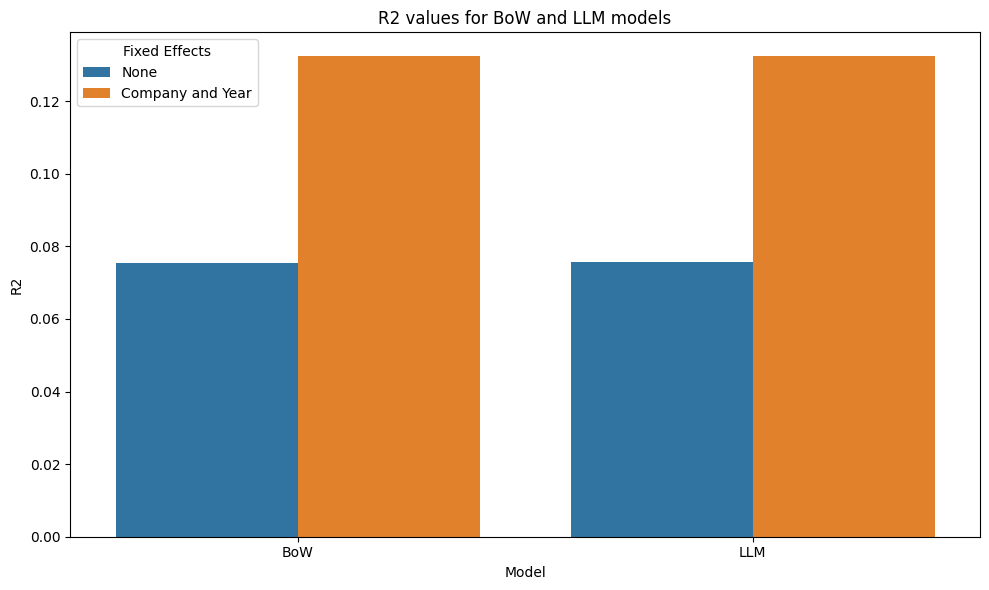

In [319]:
bow_r2 = (bow_regressions.loc['R2'].values.mean() + bow_regressions_split.loc['R2'].values.mean())/2
bow_fixed_r2 = (bow_regressions_company_and_year_fixed.loc['R2'].values.mean() + bow_regressions_split_company_and_year_fixed.loc['R2'].values.mean())/2
llm_r2 = (llm_regressions.loc['R2'].values.mean() + llm_regressions_split.loc['R2'].values.mean())/2
llm_fixed_r2 = (llm_regressions_cy_fixed.loc['R2'].values.mean() + llm_regressions_split_cy_fixed.loc['R2'].values.mean())/2

### Creating a bar plot showing the R2 values
r2_df = pd.DataFrame({'Model': ['BoW', 'LLM'], 
                      'R2': [bow_r2, llm_r2], 
                      'Fixed Effects': ['None', 'None']})
r2_df_fixed = pd.DataFrame({'Model': ['BoW', 'LLM'],
                      'R2': [bow_fixed_r2, llm_fixed_r2], 
                      'Fixed Effects': ['Company and Year', 'Company and Year']})

### Plotting
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Model', y='R2', hue='Fixed Effects', data=pd.concat([r2_df, r2_df_fixed]), ax=ax)
ax.set_title('R2 values for BoW and LLM models')
ax.set_ylabel('R2')
ax.set_xlabel('Model')
plt.legend(title='Fixed Effects')
plt.tight_layout()
#plt.savefig('figures_and_tables/r2_comparison.png', dpi=300)
plt.show()